# Continuous-Time Dynamic Network Embeddings

Reference Paper: http://ryanrossi.com/pubs/nguyen-et-al-WWW18-BigNet.pdf

This is a demo of StellarGraph's implementation of Continuous-Time Dynamic Network Embeddings. The steps outlined in this notebook show how time respecting random walks can be obtained from a graph containing time information on edges, and how these walks can be used to generate network embeddings for a link prediction task.

We compare the embeddings learnt from temporal walks with non-temporal walks in this demo.

## Dataset

The dataset used in this demo is called `enron-ia-employees`, available in Network Repository: http://networkrepository.com/ia-enron-employees.php

The dataset is an email network, where the edges contain timestamp information (i.e. when the email was sent). In order to run this notebook in your own environment, please update the following cell with the directory containing a copy of the dataset.

In [1]:
data_dir = "~/data/ia-enron-employees"

In [2]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from stellargraph import StellarGraph

%matplotlib inline

## Load graph data

In [3]:
def load_enron(data_dir):
    edges_path = os.path.join(data_dir, "ia-enron-employees.edges")
    edges = pd.read_csv(edges_path, sep=" ", header=None)

    # clean up columns
    edges.columns = ["source", "target", "x", "time"]
    edges[["source", "target"]] = edges[["source", "target"]].astype(str)
    edges = edges.drop(columns=["x"])  # unused column

    # time in seconds
    edges["time"] = edges["time"]
    nodes = pd.DataFrame(
        np.unique(pd.concat([edges["source"], edges["target"]], ignore_index=True)),
        columns=["id"],
    ).set_index("id")

    return nodes, edges

In [4]:
nodes, edges = load_enron(data_dir)

## Split edges

We want to split the edges into parts that can be used for our link prediction task:
* the oldest edges are used to create the graph structure
* the recent edges are what we are interested in predicting - we randomly split this part further into training and test sets.

In [5]:
# subset of edges to split
train_subset = 0.25
test_subset = 0.25

# number of edges to be kept in the graph
num_edges_graph = int(len(edges) * (1 - train_subset))

# keep older edges in graph, and predict more recent edges
edges_graph = edges[:num_edges_graph]
edges_other = edges[num_edges_graph:]

# split recent edges further to train and test sets
edges_train, edges_test = train_test_split(edges_other, test_size=test_subset)

print(
    f"Number of edges in graph: {len(edges_graph)}\n"
    f"Number of edges in training set: {len(edges_train)}\n"
    f"Number of edges in test set: {len(edges_test)}"
)

Number of edges in graph: 37929
Number of edges in training set: 9482
Number of edges in test set: 3161


## Create a StellarGraph

Now we can use the edges we've reserved for the graph to create an instance of the StellarGraph class

In [6]:
graph = StellarGraph(
    nodes=nodes,
    edges=edges_graph,
    source_column="source",
    target_column="target",
    edge_weight_column="time",
)

## Create link examples for training and testing

The edges that we've reserved for the train/test sets become examples of positive links. 

We also need to randomly generate some examples of negative links in order to train our classifier.

In [7]:
def create_link_examples(g, edges):
    pos = [(src, tgt) for (src, tgt) in edges[["source", "target"]].values]
    neg = sample_negative_examples(g, pos)
    return pos, neg


def sample_negative_examples(g, positive_examples):
    possible_edges_all = {
        (src, tgt) for src in g.nodes() for tgt in g.nodes() if src != tgt
    }
    possible_edges_neg = list(
        possible_edges_all.difference(
            {e for (src, tgt) in positive_examples for e in [(src, tgt), (tgt, src)]}
        )
    )
    return random.choices(possible_edges_neg, k=len(positive_examples))


pos, neg = create_link_examples(graph, edges_train)
pos_test, neg_test = create_link_examples(graph, edges_test)

It's good to verify that the data structures we've created so far from the raw data look reasonable.

`StellarGraph.info` is a useful method for inspecting the graph we've created, and we can also check that the number of link examples correspond to the train/test subset values we defined earlier.

In [8]:
print(graph.info())
print()
print(f"Training examples: {len(pos)} positive links, {len(neg)} negative links")
print(
    f"Validation examples: {len(pos_test)} positive links, {len(neg_test)} negative links"
)

StellarGraph: Undirected multigraph
 Nodes: 151, Edges: 37929

 Node types:
  default: [151]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [37929]

Training examples: 9482 positive links, 9482 negative links
Validation examples: 3161 positive links, 3161 negative links


## Running random walks
Define the random walk parameters we'd like to use

In [9]:
num_walks_per_node = 10
walk_length = 80
cw_size = 10

We try to keep the setup comparable between the use of temporal and biased (static) random walks. For temporal walks, the input parameter is defined in terms of the total number of context windows you are interested in obtaining, which differs from the traditional approach of specifying the number of walks to run per node in the graph. We calculate the number of context windows we need in terms of the traditional parameters as:

In [10]:
num_cw = len(graph.nodes()) * num_walks_per_node * (walk_length - cw_size)

We're now ready to do the walks

In [11]:
from stellargraph.data import TemporalRandomWalk

temporal_rw = TemporalRandomWalk(graph)
temporal_walks = temporal_rw.run(
    num_cw=num_cw,
    cw_size=cw_size,
    max_walk_length=walk_length,
    initial_edge_bias=None,
    walk_bias="exponential",
    p_walk_success_threshold=0.2,
)

print("Number of temporal random walks: {}".format(len(temporal_walks)))

/Users/jun021/work/stellar/stellargraph/stellargraph/core/experimental.py:88: ExperimentalWarning: TemporalRandomWalk is experimental: requires more thorough testing and documentation (see: https://github.com/stellargraph/stellargraph/issues/827, https://github.com/stellargraph/stellargraph/issues/828, https://github.com/stellargraph/stellargraph/issues/832). It may be difficult to use and may have major changes at any time.
  warnings.warn(direct_msg, ExperimentalWarning)


Number of temporal random walks: 1773


In [12]:
from stellargraph.data import BiasedRandomWalk

static_rw = BiasedRandomWalk(graph)
static_walks = static_rw.run(
    nodes=graph.nodes(), n=num_walks_per_node, length=walk_length
)

print("Number of static random walks: {}".format(len(static_walks)))

Number of static random walks: 1510


In [13]:
from gensim.models import Word2Vec

embedding_size = 128
temporal_model = Word2Vec(
    temporal_walks, size=embedding_size, window=10, min_count=0, sg=1, workers=2, iter=1
)
static_model = Word2Vec(
    static_walks, size=embedding_size, window=10, min_count=0, sg=1, workers=2, iter=1
)

For convenience, we can use the trained Word2Vec models to define helper functions that transform a node ID into a node embedding.

NOTE: Using temporal walks means we may not be able to generate an embedding for every node in the graph, since there may not be any valid temporal walks to perform that goes through a particular node. We handle this by using zeros as embeddings for such nodes to indicate that they are uninformative.

In [14]:
unseen_node_embedding = np.zeros(embedding_size)

def temporal_embedding(u):
    try:
        return temporal_model.wv[u]
    except KeyError:
        return unseen_node_embedding

def static_embedding(u):
    return static_model.wv[u]

## Node Embedding Visualisation

For visualisation of embeddings, we'll first define a helper function that we can also use later to show the TSNE visualisation.

In [15]:
def plot_tsne(title, x, y=None):
    tsne = TSNE(n_components=2)
    x_t = tsne.fit_transform(x)

    plt.figure(figsize=(7, 7))
    plt.title(title)
    if y is not None:
        red = y == 0
        green = y == 1
        plt.scatter(x_t[red, 0], x_t[red, 1], c="r", alpha=0.5)
        plt.scatter(x_t[green, 0], x_t[green, 1], c="g", alpha=0.5)
    else:
        plt.scatter(x_t[:, 0], x_t[:, 1], alpha=0.7)

We can visualise the node embeddings to take a glance at how the temporal walks have resulted in groups of nodes being clustered together

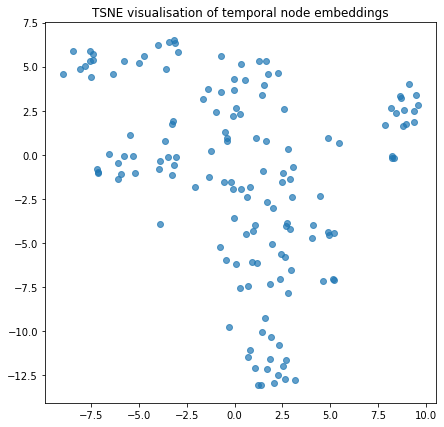

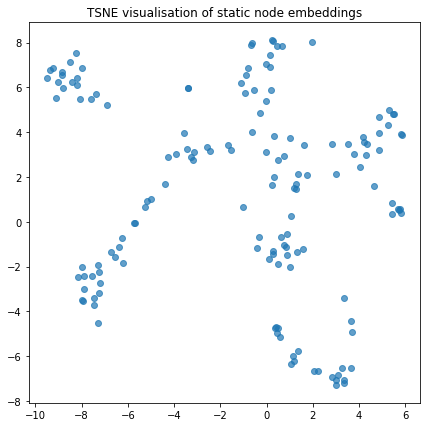

In [16]:
temporal_node_embeddings = temporal_model.wv.vectors
static_node_embeddings = static_model.wv.vectors
plot_tsne("TSNE visualisation of temporal node embeddings", temporal_node_embeddings)
plot_tsne("TSNE visualisation of static node embeddings", static_node_embeddings)

## Link Prediction using Node Embeddings

The node embeddings we've generated can now be used as input for a link prediction task. The reported AUC scores from the reference paper for this dataset are:

* Node2Vec: 0.759 
* CTDNE: 0.777

Below are a set of helper functions we can use to train and evaluate a link prediction classifier. The rest of the notebook will use the binary operator defined in the cell below. Available operators in the demo are:

* `hadamard`
* `avg`
* `l1`
* `l2` 

Alternatively, other user defined function taking two node embeddings to produce a link embedding could be used, but may affect convergence of the classifier model.

In [17]:
binary_operator = "l2"

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler


def operator_hadamard(u, v):
    return u * v


def operator_avg(u, v):
    return (u + v) / 2.0


def operator_l1(u, v):
    return np.abs(u - v)


def operator_l2(u, v):
    return (u - v) ** 2


operator_func = {
    "hadamard": operator_hadamard,
    "avg": operator_avg,
    "l1": operator_l1,
    "l2": operator_l2,
}


def link_examples_to_features(link_examples, transform_node, binary_operator):
    op_func = (
        operator_func[binary_operator]
        if isinstance(binary_operator, str)
        else binary_operator
    )
    return [
        op_func(transform_node(src), transform_node(dst)) for src, dst in link_examples
    ]


def link_prediction_clf(max_iter=2000):
    return Pipeline(
        steps=[
            ("sc", StandardScaler()),
            (
                "clf",
                LogisticRegressionCV(
                    Cs=10, cv=10, scoring="roc_auc", verbose=False, max_iter=max_iter,
                ),
            ),
        ]
    )


def evaluate_roc_auc(clf, link_features, link_labels):
    predicted = clf.predict_proba(link_features)

    # check which class corresponds to positive links
    positive_column = list(clf.classes_).index(1)
    return roc_auc_score(link_labels, predicted[:, positive_column])

We'll create some positive and negative examples to train our classifier on. The negative examples can be randomly generated from the available nodes in the graph.

In [19]:
def create_link_examples(positive_examples, negative_examples):
    return (
        positive_examples + negative_examples,
        np.repeat([1, 0], [len(positive_examples), len(negative_examples)]),
    )

link_examples, link_labels = create_link_examples(pos, neg)
link_examples_test, link_labels_test = create_link_examples(pos_test, neg_test)

#### Link prediction classifier using temporal embeddings

In [20]:
temporal_clf = link_prediction_clf()
temporal_link_features = link_examples_to_features(
    link_examples, temporal_embedding, binary_operator
)
temporal_link_features_test = link_examples_to_features(
    link_examples_test, temporal_embedding, binary_operator
)
temporal_clf.fit(temporal_link_features, link_labels)
temporal_score = evaluate_roc_auc(
    temporal_clf, temporal_link_features_test, link_labels_test
)

print("\n  **** Score on test set of links ****\n")
print(f"   Operator: {binary_operator}  Score (ROC AUC): {temporal_score:.2f}")
print("\n  ****************************")


  **** Score on test set of links ****

   Operator: l2  Score (ROC AUC): 0.96

  ****************************


#### Link prediction classifier using static embeddings

In [21]:
static_clf = link_prediction_clf()
static_link_features = link_examples_to_features(
    link_examples, static_embedding, binary_operator
)
static_link_features_test = link_examples_to_features(
    link_examples_test, static_embedding, binary_operator
)
static_clf.fit(static_link_features, link_labels)
static_score = evaluate_roc_auc(static_clf, static_link_features_test, link_labels_test)

print("\n  **** Scores on test set of links ****\n")
print(f"   Operator: {binary_operator}  Score (ROC AUC): {static_score:.2f}")
print("\n  ****************************")


  **** Scores on test set of links ****

   Operator: l2  Score (ROC AUC): 0.95

  ****************************


## Link Embedding Visualisation

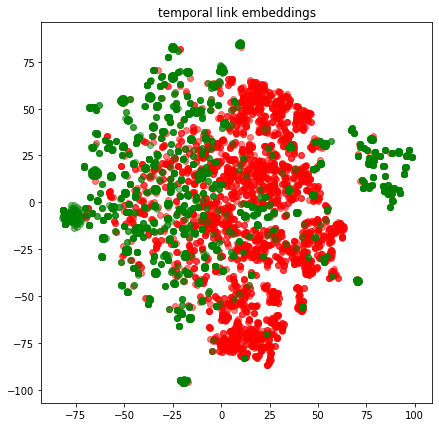

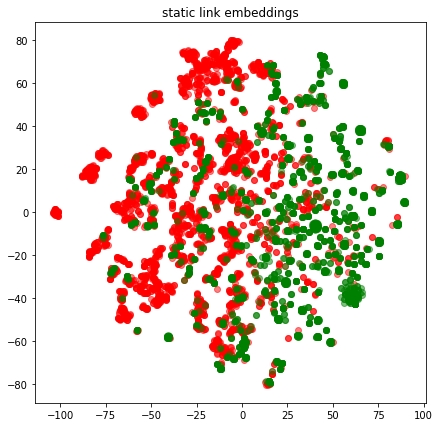

In [22]:
plot_tsne("temporal link embeddings", temporal_link_features_test, link_labels_test)
plot_tsne("static link embeddings", static_link_features_test, link_labels_test)